In [1]:
import os
import glob
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms
from ast import literal_eval
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import itertools
import random

In [2]:
torch.cuda.set_device(1) 

In [23]:
class SmallDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels = pd.read_csv(csv_file).sample(5000)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        embedding_path = os.path.join(self.root_dir, self.labels.iloc[idx,0])
        embedding = torch.load(embedding_path)[0,0,1:,:]
        label = literal_eval(self.labels.iloc[idx, 1])
        if self.transform:
            embedding = self.transform(embedding)
        return embedding, label, embedding_path

In [24]:
dataset_orig = SmallDataset(csv_file='../data/rmsd_dataset.csv',
                                    root_dir='/mnt/nasdata/vera/msa_transformer_embeddings/')

In [ ]:
all_features = []
all_labels = []
all_pdb_ids = []
all_residues = []

for i in range(len(dataset_orig)):
    feature, label, id = dataset_orig[i]
    for residue in range(feature.shape[0]):
        all_features.append(feature[residue].cpu().numpy())
        all_labels.append(label[residue])
        all_pdb_ids.append(id)
        all_residues.append(residue)
    print(i)

print(len(all_features), len(all_labels))

feature_tensor = torch.from_numpy(np.stack(all_features))
torch.save(feature_tensor, '../data/5k_protein_dataset/5k_protein_tensor.pt')
label_tuples = list(zip(all_pdb_ids,all_residues,all_labels))
labels_df = pd.DataFrame(label_tuples, columns=['pdb','residue','rmsd'])
labels_df.to_csv('../data/5k_protein_dataset/5k_protein_labels.csv')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62


KeyboardInterrupt: 

In [148]:
feature_tensor = torch.load('../data/500_protein_dataset/500_protein_tensor.pt')
labels_df = pd.read_csv('../data/500_protein_dataset/500_protein_labels.csv')
print(feature_tensor.shape)
print(labels_df.shape)

torch.Size([112801, 768])
(112801, 4)


In [149]:
# Iterate over different rmsd thresholds and print the percentage of the dataset that is selected
for i in range(1,10):
    select = labels_df['rmsd'] > i/5
    select_df = labels_df[select]
    full_length = len(labels_df)
    select_length = len(select_df)
    print("{:.2%}".format(select_length/full_length))

21.18%
13.67%
10.85%
9.24%
8.16%
7.26%
6.56%
5.94%
5.44%


In [3]:
RMSD_THRESHOLD = 0.2

In [5]:
class SmallDataset500(Dataset):
    def __init__(self, pt_file, label_csv, transform=None):
        self.features = torch.load(pt_file)
        self.labels = pd.read_csv(label_csv)
        self.labels = self.labels.drop(columns=['Unnamed: 0'])
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        features = self.features[idx]
        label = int(self.labels.loc[idx, 'rmsd'] >= RMSD_THRESHOLD)
        if self.transform:
            features = self.transform(features)
        return features, label

In [6]:
dataset = SmallDataset500(pt_file='../data/500_protein_dataset/500_protein_tensor.pt', label_csv='../data/500_protein_dataset/500_protein_labels.csv')

In [7]:
# Test some of the data
for i in range(10, 50):
    feature, label = dataset[i]
    print(feature.shape, label)

torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 1
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0
torch.Size([768]) 0


## The following code is written by copilot

In [8]:
# Split the dataset into train and test sets.
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [9]:
# Test the split
print(len(train_dataset), len(test_dataset))

90240 22561


In [10]:
# Create the dataloaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Test the dataloaders
for i, (features, labels) in enumerate(train_loader):
    print(features.shape, labels.shape)
    break

torch.Size([128, 768]) torch.Size([128])


In [11]:
print(labels)
print(features)

tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0])
tensor([[-1.3566, -0.0953,  1.8045,  ..., -0.9411,  0.4137,  0.0075],
        [-0.6833, -0.6870, -0.5969,  ..., -0.9105,  0.3010, -0.3303],
        [-0.8243, -0.1624, -0.6868,  ...,  0.6887, -0.3415, -0.8316],
        ...,
        [-0.7919, -1.0166,  0.2467,  ..., -1.2035, -0.6025, -0.1938],
        [-0.8047, -0.3926,  0.5995,  ..., -1.2277,  1.0002,  0.1274],
        [-1.1114, -0.7191,  0.0479,  ..., -0.2406,  0.2433, -1.1319]])


In [12]:
# Define a binary classifier with five hidden layers
class SimpleClassifier(nn.Module):
    def __init__(self):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

        

In [17]:
# Improved model using regularization and batch normalization
class ImprovedClassifier(nn.Module):
    def __init__(self):
        super(ImprovedClassifier, self).__init__()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(256)
        self.batchnorm3 = nn.BatchNorm1d(128)
        self.batchnorm4 = nn.BatchNorm1d(64)

    def forward(self, x, training=False):
        x = self.relu(self.batchnorm1(self.fc1(x)))
        if training:
            x = self.dropout(x)
        x = self.relu(self.batchnorm2(self.fc2(x)))
        if training:
            x = self.dropout(x)
        x = self.relu(self.batchnorm3(self.fc3(x)))
        if training:
            x = self.dropout(x)
        x = self.relu(self.batchnorm4(self.fc4(x)))
        if training:
            x = self.dropout(x)
        x = self.sigmoid(self.fc5(x))
        return x

In [18]:

model = SimpleClassifier()
model = ImprovedClassifier()
model.cuda()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Train the model
num_epochs = 50
for epoch in range(num_epochs):
    for i, (features, labels) in enumerate(train_loader):
        features = features.cuda()
        labels = labels.cuda()
        # Forward pass
        outputs = model(features, training=True)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.item()))

Epoch [1/50], Step [100/705], Loss: 0.6112
Epoch [1/50], Step [200/705], Loss: 0.5752
Epoch [1/50], Step [300/705], Loss: 0.5994
Epoch [1/50], Step [400/705], Loss: 0.5520
Epoch [1/50], Step [500/705], Loss: 0.5562
Epoch [1/50], Step [600/705], Loss: 0.5139
Epoch [1/50], Step [700/705], Loss: 0.5334
Epoch [2/50], Step [100/705], Loss: 0.5200
Epoch [2/50], Step [200/705], Loss: 0.5607
Epoch [2/50], Step [300/705], Loss: 0.5111
Epoch [2/50], Step [400/705], Loss: 0.4891
Epoch [2/50], Step [500/705], Loss: 0.5036
Epoch [2/50], Step [600/705], Loss: 0.5174
Epoch [2/50], Step [700/705], Loss: 0.5080
Epoch [3/50], Step [100/705], Loss: 0.5309
Epoch [3/50], Step [200/705], Loss: 0.5463
Epoch [3/50], Step [300/705], Loss: 0.5227
Epoch [3/50], Step [400/705], Loss: 0.5331
Epoch [3/50], Step [500/705], Loss: 0.5009
Epoch [3/50], Step [600/705], Loss: 0.5187
Epoch [3/50], Step [700/705], Loss: 0.5443
Epoch [4/50], Step [100/705], Loss: 0.5066
Epoch [4/50], Step [200/705], Loss: 0.4936
Epoch [4/50

In [19]:
# Test the accuracy of the model on the train set
correct = 0
total = 0
with torch.no_grad():
    for i, (features, labels) in enumerate(train_loader):
        features = features.cuda()
        labels = labels.cuda()
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Train set accuracy:   %d %%' % (100 * correct / total))

# Test the accuracy, precision, recall and F1 score of the model
true_negative = 0
false_negative = 0
true_positive = 0
false_positive = 0

with torch.no_grad():
    for i, (features, labels) in enumerate(test_loader):
        features = features.cuda()
        labels = labels.cuda()
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        for j in range(len(labels)):
            if labels[j] == 0 and predicted[j] == 0:
                true_negative += 1
            elif labels[j] == 1 and predicted[j] == 0:
                false_negative += 1
            elif labels[j] == 1 and predicted[j] == 1:
                true_positive += 1
            elif labels[j] == 0 and predicted[j] == 1:
                false_positive += 1

print('Test set accuracy:    %d %%' % (100 * (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)))
print('Test set precision:   %d %%' % (100 * true_positive / (true_positive + false_positive)))
print('Test set recall:      %d %%' % (100 * true_positive / (true_positive + false_negative)))
print('Test set F1 score     %d %%' % (100 * 2 * true_positive / (2 * true_positive + false_positive + false_negative)))

Train set accuracy:   93 %
Test set accuracy:    82 %
Test set precision:   62 %
Test set recall:      44 %
Test set F1 score     51 %


ValueError: expected 2D or 3D input (got 1D input)

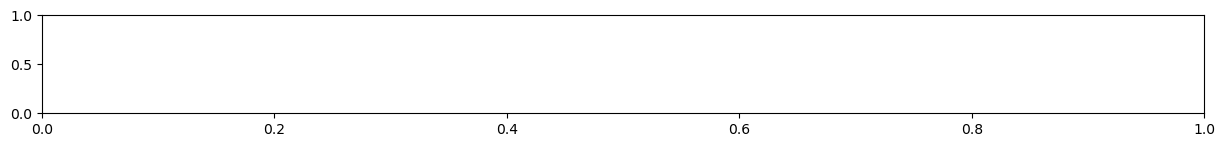

In [25]:

fig = plt.figure(figsize=(15, 15))

for i in range(10):
    # Add subplot vertically
    ax = fig.add_subplot(10, 1, i+1)

    # Test for a single protein
    test_protein = dataset_orig[random.randint(0, len(dataset_orig))]

    # Get the predicted labels for each residue
    predicted_labels = []
    with torch.no_grad():
        for residue in test_protein[0]:
            #residue = torch.tensor(residue).cuda()
            #residue = residue.view(1, 1, 768)
            output = model(residue)
            _, predicted = torch.max(output.data, 1)
            predicted_labels.append(predicted.cpu().numpy()[0]*RMSD_THRESHOLD)

    # Get the actual labels for each residue
    actual_labels = []
    correct_labels = []
    for residue in test_protein[1]:
        actual_labels.append(residue)
        correct_labels.append(int(residue >= RMSD_THRESHOLD))

    # Get a list of correctly predicted labels
    correctly_predicted_labels = []
    for i in range(len(predicted_labels)):
        if correct_labels[i] == 1 and predicted_labels[i] == RMSD_THRESHOLD:
            correctly_predicted_labels.append(RMSD_THRESHOLD)
        elif correct_labels[i] == 0 and predicted_labels[i] == 0:
            correctly_predicted_labels.append(0)
        else:
            correctly_predicted_labels.append(None)

    # Plot the actual labels as black
    ax.plot(actual_labels, color='black')
    ax.plot(predicted_labels, color='red', marker='o', linestyle='None')
    ax.plot(correctly_predicted_labels, color='green', marker='o', linestyle='None')
    ax.set_ylim(0, RMSD_THRESHOLD*5)
    # Fill under the curve in a rainbow gradient
    ax.fill_between(range(len(actual_labels)), actual_labels, color='black', alpha=0.2)

plt.show()


    